## 2. Hourly forecasting

The first task that need to be done is selecting an appropriate range of data to use for training and testing of the model. The range should have a sufficiently high number of meters reporting values in order to maximise the reliability of the generated forecasts.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
import sklearn.metrics as metrics
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Question 2a

In [3]:
df = pd.read_csv('hourly_reading_dataset.csv')
df['datetime'] = pd.to_datetime(df.datetime, format = '%Y-%m-%d %H:%M:%S') # format as time
df.head()

datetime  dataid  meter_value  meter_value_differential  \
0 2015-10-01 00:00:00      35      93470.0                       0.0   
1 2015-10-01 01:00:00      35      93470.0                       0.0   
2 2015-10-01 02:00:00      35      93470.0                       0.0   
3 2015-10-01 03:00:00      35      93470.0                       0.0   
4 2015-10-01 04:00:00      35      93470.0                       0.0   

   if_outlier  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

The following block of code provides a summary of the number of meters with a full set of hourly readings on each day.

In [4]:
# making a column of dates
df['date'] = df['datetime'].dt.date 
df['date'] = pd.to_datetime(df.date, format = '%Y-%m-%d') 

# counting the number of measurements that a meter has in a day
df['day_count'] = df.groupby(['dataid', 'date'])['date'].transform('count')
df['full_day'] = df['day_count'] == 24



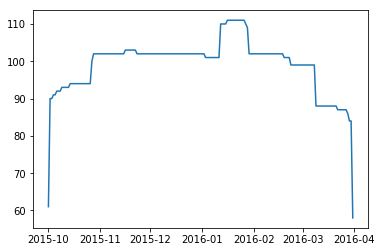

In [5]:
# counting the number of meters with a full day's worth of hourly readings 
df_summary = df.groupby(['dataid', 'date']).first().reset_index()
df_summary = df_summary[df_summary['full_day']] 
df_summary = df_summary.groupby('date').count().reset_index()

# tidying up produced df 
df_summary['no_of_meters_in_day'] = df_summary['datetime']
df_summary = df_summary[['date', 'no_of_meters_in_day']]
df_summary

plt.plot(df_summary['date'], df_summary['no_of_meters_in_day'])

It's clear from the above plot that a threshold of 80 meters reporting in a day can be set with only a marginal loss in data. As this is roughly 70% of the (115) meters not filtered in the previous data cleaning exercise, we decided that a limit of 80 was a good value to set as the threshold for the analysis. This means that and only the first and last days (1st Oct 2015 and 31st March 2016) will be removed from this analysis.

In [6]:
df_filtered = df[ (df['date'] != "2015-10-01") & (df['date'] != "2016-03-31")]
df_filtered = df_filtered.round(decimals = 2)
df_filtered = df_filtered[['datetime', 'dataid', 'meter_value_differential']]
df_filtered.rename(columns = {'meter_value_differential' : 'y'}, inplace = True)

In [7]:
def previous_hours(group):
    for k in range(23):
        col = 'y_' + str((k + 1))
        group[col] = group['y'].shift(k+1)   
    return group

df_q2 = df_filtered.groupby('dataid', sort = False).apply(previous_hours).copy(deep = True)

# Needed for Q3
def future_and_previous_hours(group):
    # future 23 hours
    for k in range (23):
        col = 'y+' + str((k+1))
        group[col] = group['y'].shift(-(k+1))
    # previous 143 hours
    for k in range(144):
        col = 'y-' + str((k + 1))
        group[col] = group['y'].shift(k+1)  
    return group


df_q3 = df_filtered.groupby('dataid', sort = False).apply(future_and_previous_hours).copy(deep = True)
df_q3 = df_q3.rename(columns = {"datetime": "DateTime"})


## Question 2b and c

In [8]:
df = df_q2

In [9]:
# delete if any rows have nans
print(df.shape)
df = df.dropna()
print(df.shape)
df.head()

(432595, 26)
(429994, 26)


datetime  dataid    y  y_1  y_2  y_3  y_4  y_5  y_6  y_7  ...   \
47 2015-10-02 23:00:00      35  0.0  0.0  4.0  8.0  2.0  6.0  6.0  6.0  ...    
48 2015-10-03 00:00:00      35  0.0  0.0  0.0  4.0  8.0  2.0  6.0  6.0  ...    
49 2015-10-03 01:00:00      35  0.0  0.0  0.0  0.0  4.0  8.0  2.0  6.0  ...    
50 2015-10-03 02:00:00      35  0.0  0.0  0.0  0.0  0.0  4.0  8.0  2.0  ...    
51 2015-10-03 03:00:00      35  2.0  0.0  0.0  0.0  0.0  0.0  4.0  8.0  ...    

    y_14  y_15  y_16  y_17  y_18  y_19  y_20  y_21  y_22  y_23  
47   0.0   2.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0  
48   0.0   0.0   2.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0  
49   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   2.0   0.0  
50   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   2.0  
51   0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  

[5 rows x 26 columns]

In [10]:
### calculate average of the readings at each timestep
df_mean = df.groupby(['datetime'], as_index=False).mean()

# drop id col
df_mean = df_mean.drop(columns = ['dataid'])

In [11]:
df_mean = df_mean.sort_values(by = ['datetime'])
df_mean.tail()

datetime         y       y_1       y_2       y_3       y_4  \
4316 2016-03-30 19:00:00  2.479048  2.353452  1.632262  1.092976  0.873214   
4317 2016-03-30 20:00:00  3.284405  2.479048  2.353452  1.632262  1.092976   
4318 2016-03-30 21:00:00  2.965714  3.284405  2.479048  2.353452  1.632262   
4319 2016-03-30 22:00:00  2.437976  2.965714  3.284405  2.479048  2.353452   
4320 2016-03-30 23:00:00  1.600119  2.437976  2.965714  3.284405  2.479048   

           y_5       y_6       y_7       y_8    ...         y_14      y_15  \
4316  1.047738  1.434524  1.562500  2.015000    ...     0.904524  0.863452   
4317  0.873214  1.047738  1.434524  1.562500    ...     2.511786  0.904524   
4318  1.092976  0.873214  1.047738  1.434524    ...     3.894167  2.511786   
4319  1.632262  1.092976  0.873214  1.047738    ...     3.016667  3.894167   
4320  2.353452  1.632262  1.092976  0.873214    ...     2.926310  3.016667   

          y_16      y_17      y_18      y_19      y_20      y_21      y_22  \
4316  0.743571  0.849167  0.908571  0.876905  1.313333  2.250714  2.858333   
4317  0.863452  0.743571  0.849167  0.908571  0.876905  1.313333  2.250714   
4318  0.904524  0.863452  0.743571  0.849167  0.908571  0.876905  1.313333   
4319  2.511786  0.904524  0.863452  0.743571  0.849167  0.908571  0.876905   
4320  3.894167  2.511786  0.904524  0.863452  0.743571  0.849167  0.908571   

          y_23  
4316  3.972976  
4317  2.858333  
4318  2.250714  
4319  1.313333  
4320  0.876905  

[5 rows x 25 columns]

In [12]:
df_mean.to_csv('df_mean.csv', index = False)

### Dataset ready. Start machine learning models:

In [13]:
df_mean = pd.read_csv('df_mean.csv')
df_mean.shape

(4321, 25)

In [14]:
# split with 70 30
dataset = df_mean.values
# split into input (X) and output (Y) variables
X = dataset[:,2::]
Y = dataset[:,1]
times = dataset[:,0]

In [15]:
row_70perc = round(len(X)*0.7)
train_X = X[0:row_70perc, :]
test_X = X[row_70perc+1::, :]
train_Y = Y[0:row_70perc]
test_Y = Y[row_70perc+1::]

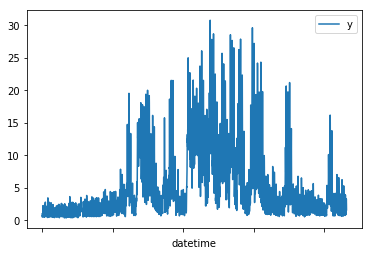

In [16]:
df_mean.plot(x = 'datetime', y = 'y')

### Functions for calculating mse & mae

In [17]:
def calc_mse(y_pred, y):
    summation = 0  #variable to store the summation of differences
    n = len(y) #finding total number of items in list
    
    for i in range (0,n):  #looping through each element of the list
        diff= y[i] - y_pred[i]  #finding the difference between observed and predicted value
        squared_difference = diff**2  #taking square of the differene 
        summation = summation + squared_difference  #taking a sum of all the differences
    
    MSE = summation/n  #dividing summation by total values to obtain average
    print("The Mean Square Error is: " , MSE)
    
    return MSE
    
def calc_mae(y_pred, y):
    summation = 0  #variable to store the summation of differences
    n = len(y) #finding total number of items in list
    
    for i in range (0,n):  #looping through each element of the list
        diff= abs(y[i] - y_pred[i])  #finding the difference between observed and predicted value
        summation = summation + diff  #taking a sum of all the differences
    
    MAE = summation/n  #dividing summation by total values to obtain average
    print("The Mean Absolute Error is: " , MAE)
    
    return MAE

In [18]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

### Linear Model

In [19]:
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm

In [20]:
# We create the model.
lr = lm.LinearRegression()
# We train the model on our training dataset.
lr.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
train_Y_pred = lr.predict(train_X)

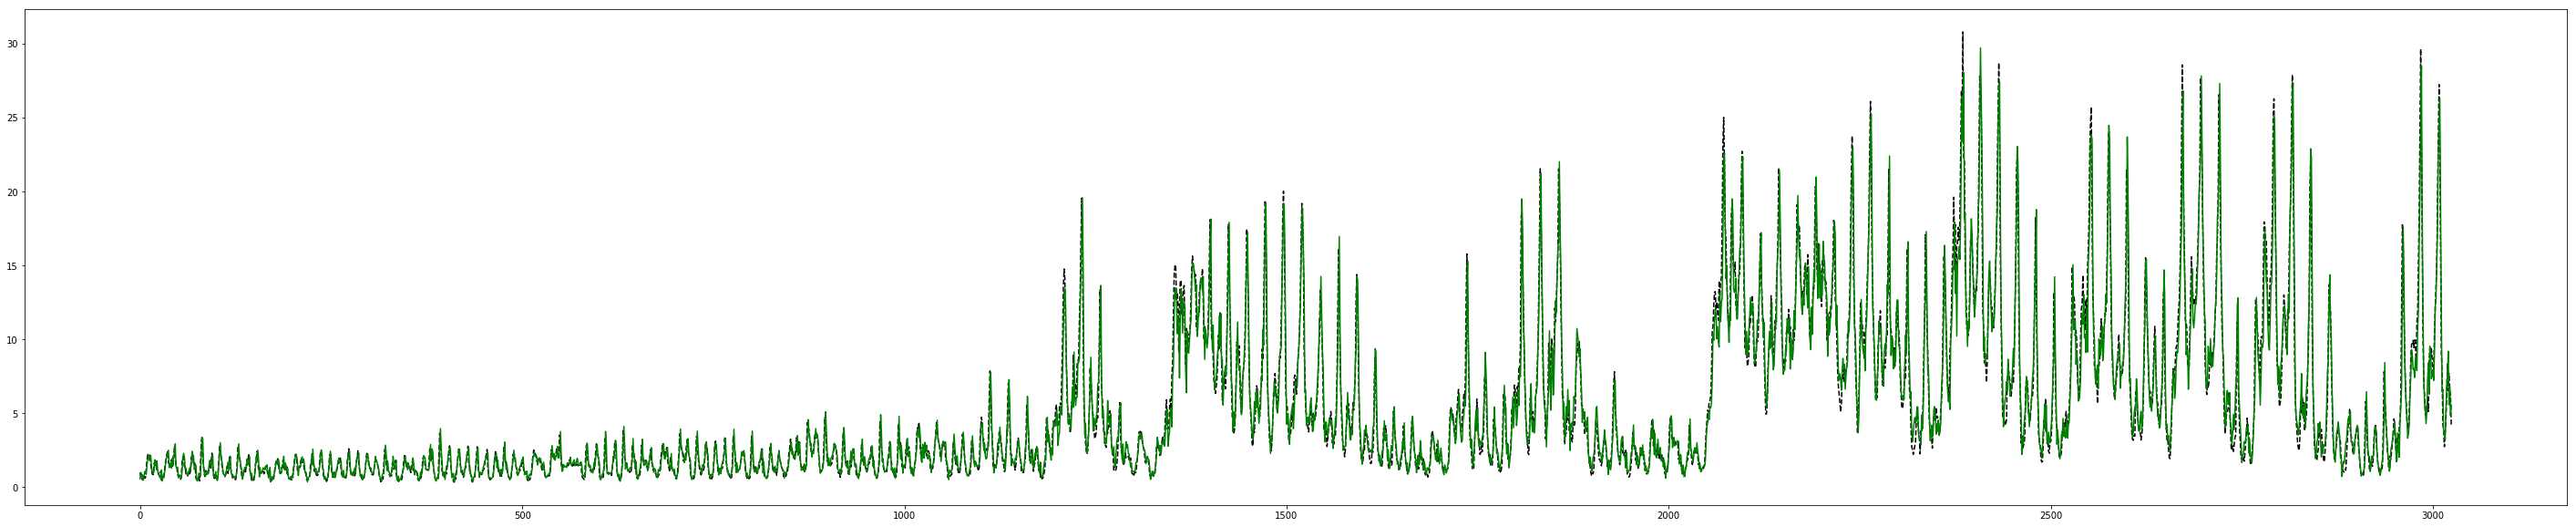

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(train_Y)), train_Y, '--k')
ax.plot(range(0,len(train_Y)), train_Y_pred, 'g')

In [23]:
mae_lm_train = calc_mae(y=train_Y, y_pred=train_Y_pred)
mse_lm_train = calc_mse(y=train_Y, y_pred=train_Y_pred)

The Mean Absolute Error is:  0.7766155525655751
The Mean Square Error is:  1.4662212549347928


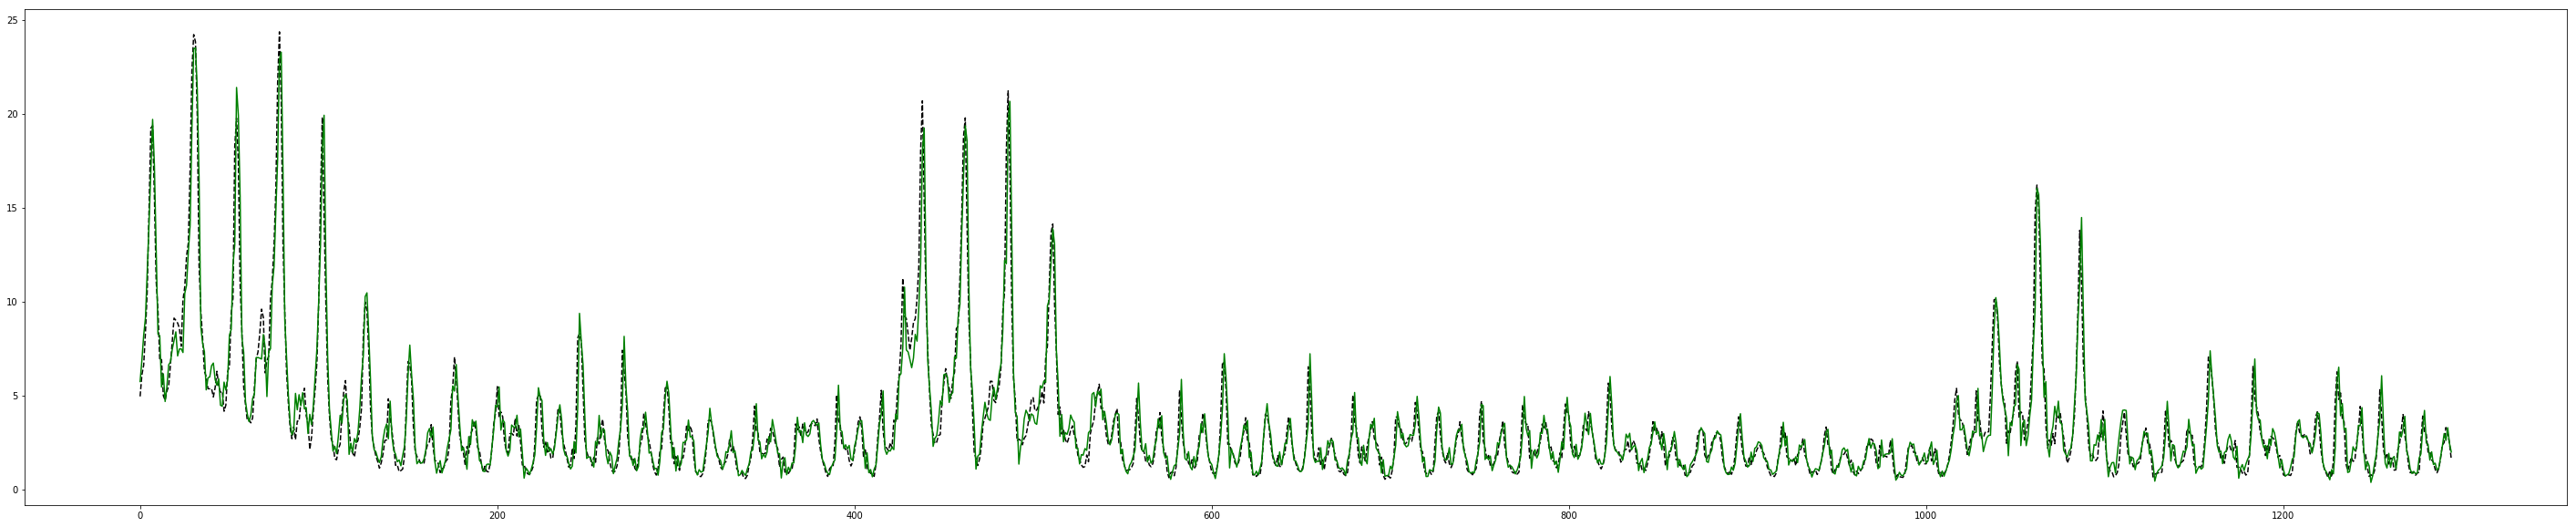

In [24]:
test_Y_pred = lr.predict(test_X)
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y, '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred, 'g')

In [25]:
mae_lm_test = calc_mae(y=test_Y, y_pred=test_Y_pred)
mse_lm_test = calc_mse(y=test_Y, y_pred=test_Y_pred)

The Mean Absolute Error is:  0.6073767837183542
The Mean Square Error is:  0.8571161471926663


In [26]:
coefficient_of_dermination = r2_score(test_Y, test_Y_pred)
coefficient_of_dermination

0.9205345504526852

best fit line:
y = 0.23 + 0.95x


Text(0,0.5,'Predicted Hourly Consumption')

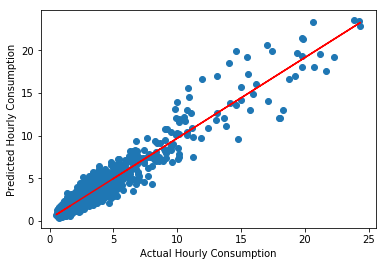

In [27]:
# solution
a, b = best_fit(test_Y, test_Y_pred)
plt.scatter(test_Y, test_Y_pred)
yfit = [a + b * test_Y_point for test_Y_point in test_Y]
plt.plot(test_Y, yfit, '-r')
plt.xlabel("Actual Hourly Consumption")
plt.ylabel("Predicted Hourly Consumption")

### SVR

In [28]:
from sklearn.svm import SVR 

In [29]:
model = SVR(C = 100, gamma = 0.01)
print(model)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [30]:
model.fit(train_X,train_Y)
train_Y_pred = model.predict(train_X)

The Mean Absolute Error is:  0.15126836205478528
The Mean Square Error is:  0.05294456951796646


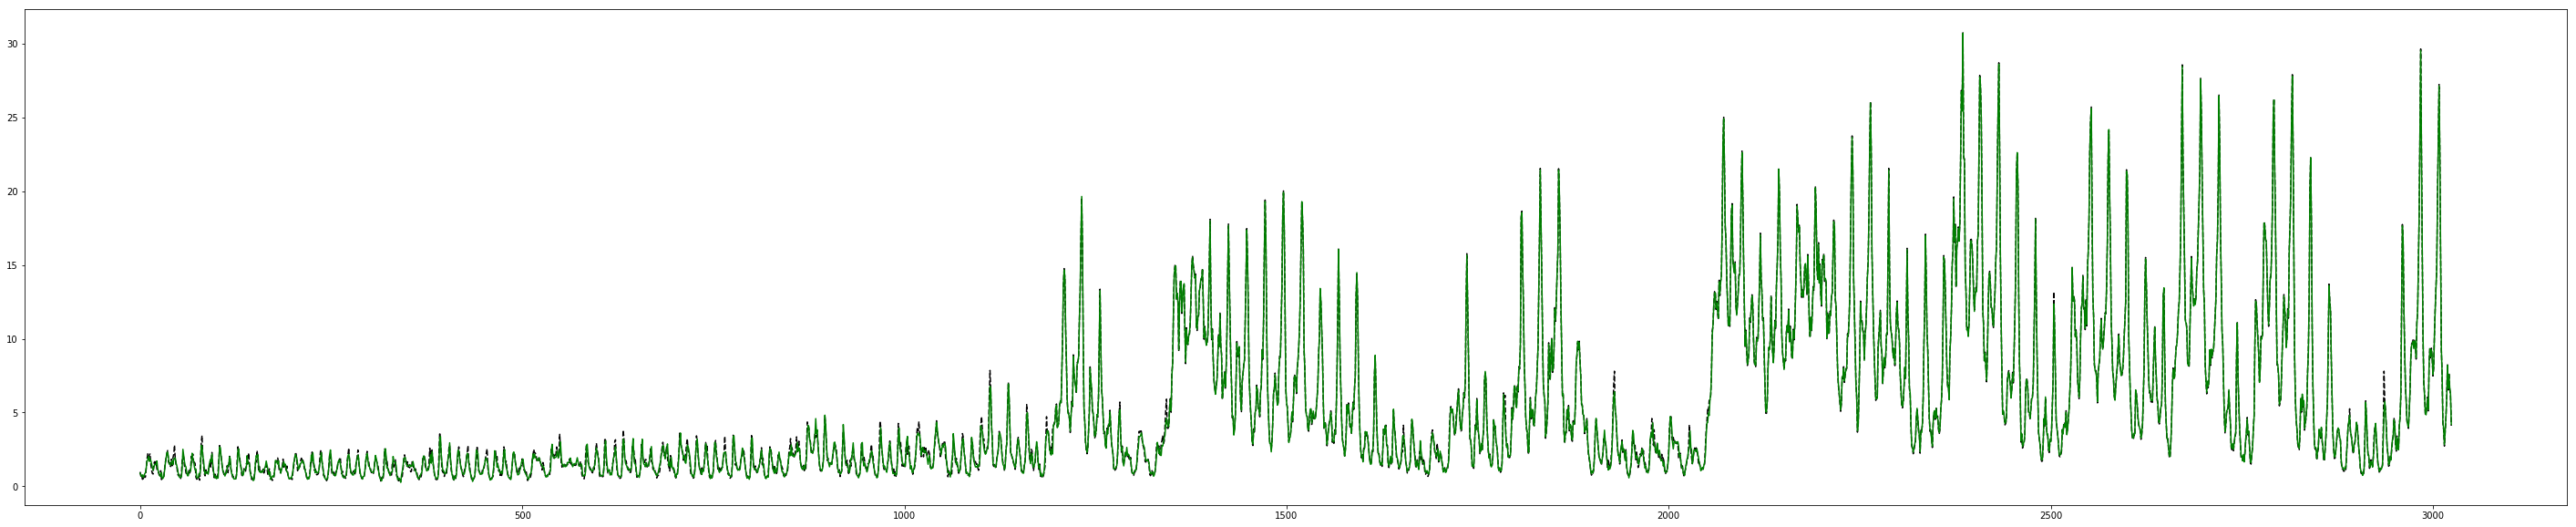

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(train_Y)), train_Y, '--k')
ax.plot(range(0,len(train_Y)), train_Y_pred, 'g')
mae_svr_train = calc_mae(y=train_Y, y_pred=train_Y_pred)
mse_svr_train = calc_mse(y=train_Y, y_pred=train_Y_pred)

The Mean Absolute Error is:  0.6306160600856342
The Mean Square Error is:  0.8306711411688302


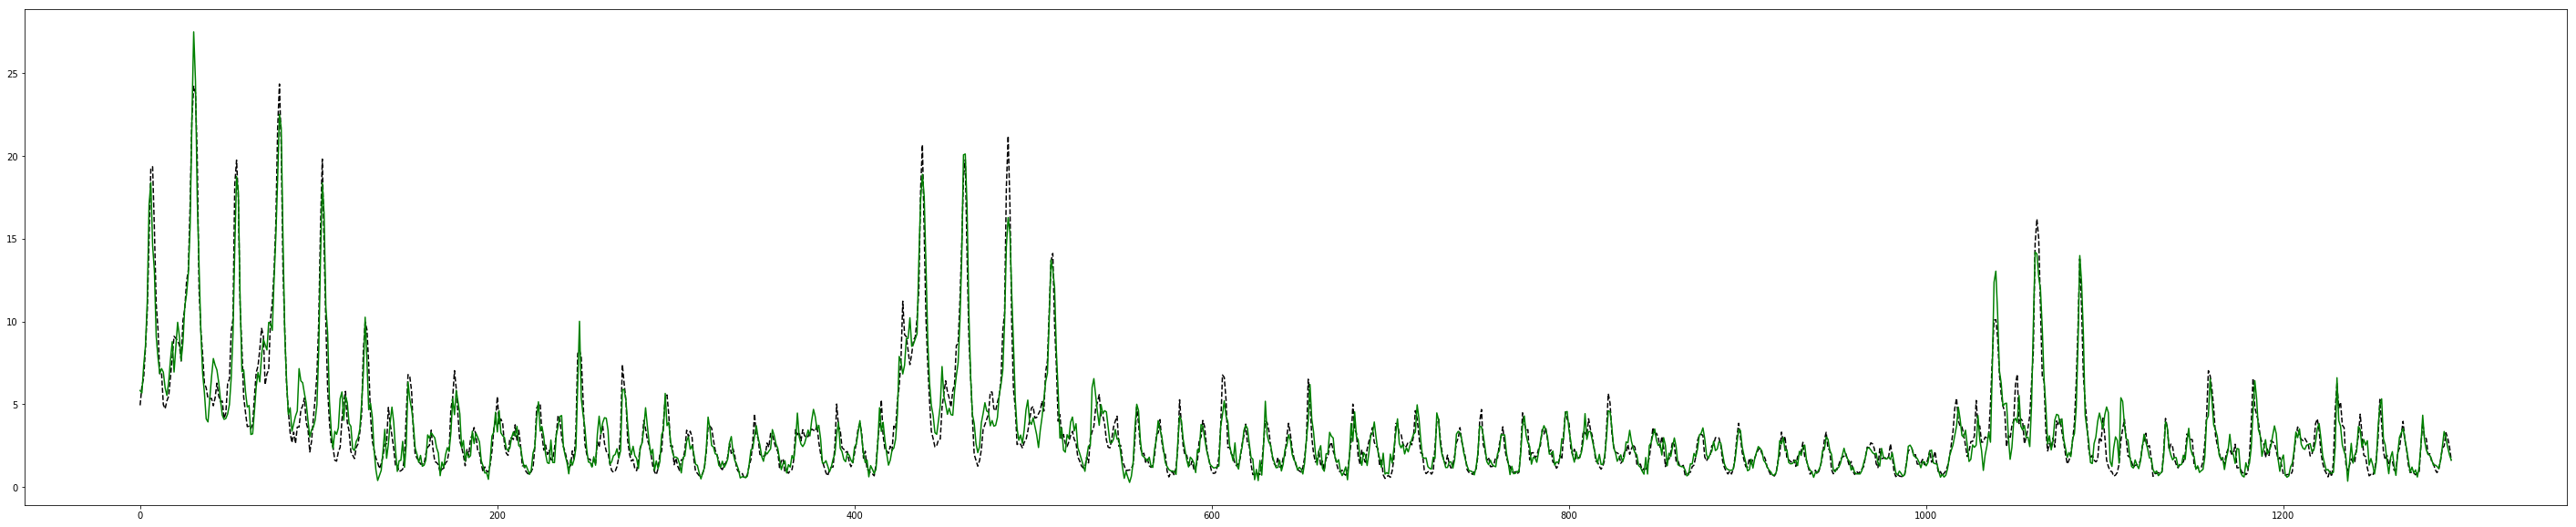

In [32]:
test_Y_pred = model.predict(test_X)
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y, '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred, 'g')

mae_svr_test = calc_mae(y=test_Y, y_pred=test_Y_pred)
mse_svr_test = calc_mse(y=test_Y, y_pred=test_Y_pred)

In [33]:
calc_mse(test_Y, test_Y_pred)
calc_mse(train_Y, train_Y_pred)

The Mean Square Error is:  0.8306711411688302
The Mean Square Error is:  0.05294456951796646


0.05294456951796646

In [34]:
coefficient_of_dermination = r2_score(test_Y, test_Y_pred)
coefficient_of_dermination

0.9229863351948682

best fit line:
y = 0.26 + 0.94x


Text(0,0.5,'Predicted Hourly Consumption')

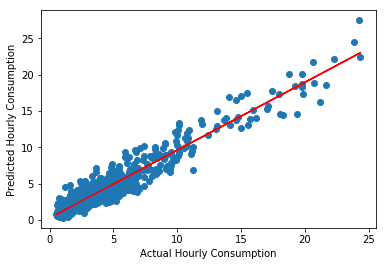

In [35]:
# solution
a, b = best_fit(test_Y, test_Y_pred)
plt.scatter(test_Y, test_Y_pred)
yfit = [a + b * test_Y_point for test_Y_point in test_Y]
plt.plot(test_Y, yfit, '-r')
plt.xlabel("Actual Hourly Consumption")
plt.ylabel("Predicted Hourly Consumption")

# 3. Project Proposal: Day-ahead forecasting (for Demand-Side Response programs)

The code here trains a linear model and a neural network without and with weather data in order to predict the next 24-hours consumption using the consumption of the previous 6 days.

In [33]:
df_shifted = df_q3
df_shifted['DateTime'] = pd.to_datetime(df_shifted.DateTime, format = '%Y-%m-%d %H:%M:%S') # format as time

In [34]:
# find nans
print(df_shifted.shape)
df_shifted = df_shifted.dropna()
print(df_shifted.shape)
df_shifted.head()

######################### Need Jasmine's new csv file... Should have seen more NaN rows

(432595, 170)
(413722, 170)


DateTime  dataid    y  y+1  y+2  y+3  y+4  y+5  y+6  y+7  ...  \
168 2015-10-08 00:00:00      35  0.0  0.0  0.0  1.0  0.5  0.5  0.0  4.0  ...   
169 2015-10-08 01:00:00      35  0.0  0.0  1.0  0.5  0.5  0.0  4.0  4.0  ...   
170 2015-10-08 02:00:00      35  0.0  1.0  0.5  0.5  0.0  4.0  4.0  0.0  ...   
171 2015-10-08 03:00:00      35  1.0  0.5  0.5  0.0  4.0  4.0  0.0  0.0  ...   
172 2015-10-08 04:00:00      35  0.5  0.5  0.0  4.0  4.0  0.0  0.0  2.0  ...   

     y-135  y-136  y-137  y-138  y-139  y-140  y-141  y-142  y-143  y-144  
168    0.0    2.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0  
169    0.0    0.0    2.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0  
170    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    2.0    0.0  
171    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    2.0  
172    0.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0  

[5 rows x 170 columns]

In [35]:
# find no. of meters
no_of_houses = len(df_shifted['dataid'].unique())


# aggregate to calculate the averaged reading
df_mean = df_shifted.groupby(['DateTime'], as_index=False).mean()
df_mean = df_mean.drop(columns = ['dataid'])
df_mean = df_mean.sort_values(by = ['DateTime'])

# multiply average by total no. of houses
df_mean.iloc[:, 1::] = df_mean.iloc[:,1::]*no_of_houses

df_mean.head()   
##################################### the script is okay but the csv file needs to be changed!

DateTime          y        y+1         y+2         y+3  \
0 2015-10-08 00:00:00  69.771222  74.617667   62.928444   59.626333   
1 2015-10-08 01:00:00  74.617667  62.928444   59.626333   55.884778   
2 2015-10-08 02:00:00  62.928444  59.626333   55.884778   86.193889   
3 2015-10-08 03:00:00  59.626333  55.884778   86.193889  190.241778   
4 2015-10-08 04:00:00  55.884778  86.193889  190.241778  307.899889   

          y+4         y+5         y+6         y+7         y+8  ...  \
0   55.884778   86.193889  190.241778  307.899889  253.019556  ...   
1   86.193889  190.241778  307.899889  253.019556  235.755667  ...   
2  190.241778  307.899889  253.019556  235.755667  186.023111  ...   
3  307.899889  253.019556  235.755667  186.023111  143.623000  ...   
4  253.019556  235.755667  186.023111  143.623000   85.013667  ...   

        y-135       y-136       y-137       y-138       y-139       y-140  \
0  162.029444  291.389333  252.253667  183.574778   53.662444   50.912778   
1  133.942667  162.029444  291.389333  252.253667  183.574778   53.662444   
2   99.025667  133.942667  162.029444  291.389333  252.253667  183.574778   
3  116.088667   99.025667  133.942667  162.029444  291.389333  252.253667   
4  105.341111  116.088667   99.025667  133.942667  162.029444  291.389333   

        y-141       y-142      y-143      y-144  
0   70.273444   52.758444  71.190000  81.460444  
1   50.912778   70.273444  52.758444  71.190000  
2   53.662444   50.912778  70.273444  52.758444  
3  183.574778   53.662444  50.912778  70.273444  
4  252.253667  183.574778  53.662444  50.912778  

[5 rows x 169 columns]

### Prepare X & Y

In [36]:
# split to input, output
dataset = df_mean.values
# split into input (X) and output (Y) variables
X = dataset[:,25::]
Y = dataset[:,1:25]
assert X.shape[1] == 24*6

In [37]:
split_1 = round(len(X)*0.7)

train_X = X[0:split_1, :]
test_X = X[split_1::,:]
assert len(X) == len(train_X)+len(test_X)

train_Y = Y[0:split_1]
test_Y = Y[split_1::]

# now Xs and Ys are all set. Can start training

### Linear Model

In [38]:
import numpy as np
import scipy.stats as st
import sklearn.linear_model as lm

In [39]:
# We create the model.
lr = lm.LinearRegression()
# We train the model on our training dataset.
lr.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
def calc_mse(y_pred, y):
    summation = 0  #variable to store the summation of differences
    n = len(y) #finding total number of items in list
    
    for i in range (0,n):  #looping through each element of the list
        diff= y[i] - y_pred[i]  #finding the difference between observed and predicted value
        squared_difference = diff**2  #taking square of the differene 
        summation = summation + squared_difference  #taking a sum of all the differences
    
    MSE = summation/n  #dividing summation by total values to obtain average
    print("The Mean Square Error is: " , np.array(MSE,dtype=int))
    
    return MSE
    
def calc_mae(y_pred, y):
    summation = 0  #variable to store the summation of differences
    n = len(y) #finding total number of items in list
    
    for i in range (0,n):  #looping through each element of the list
        diff= abs(y[i] - y_pred[i])  #finding the difference between observed and predicted value
        summation = summation + diff  #taking a sum of all the differences
    
    MAE = summation/n  #dividing summation by total values to obtain average
    print("The Mean Absolute Error is: " , np.array(MAE,dtype=int))
    
    return MAE

Text(0.5, 1.0, 'One hour ahead: Predicted vs actual consumption')

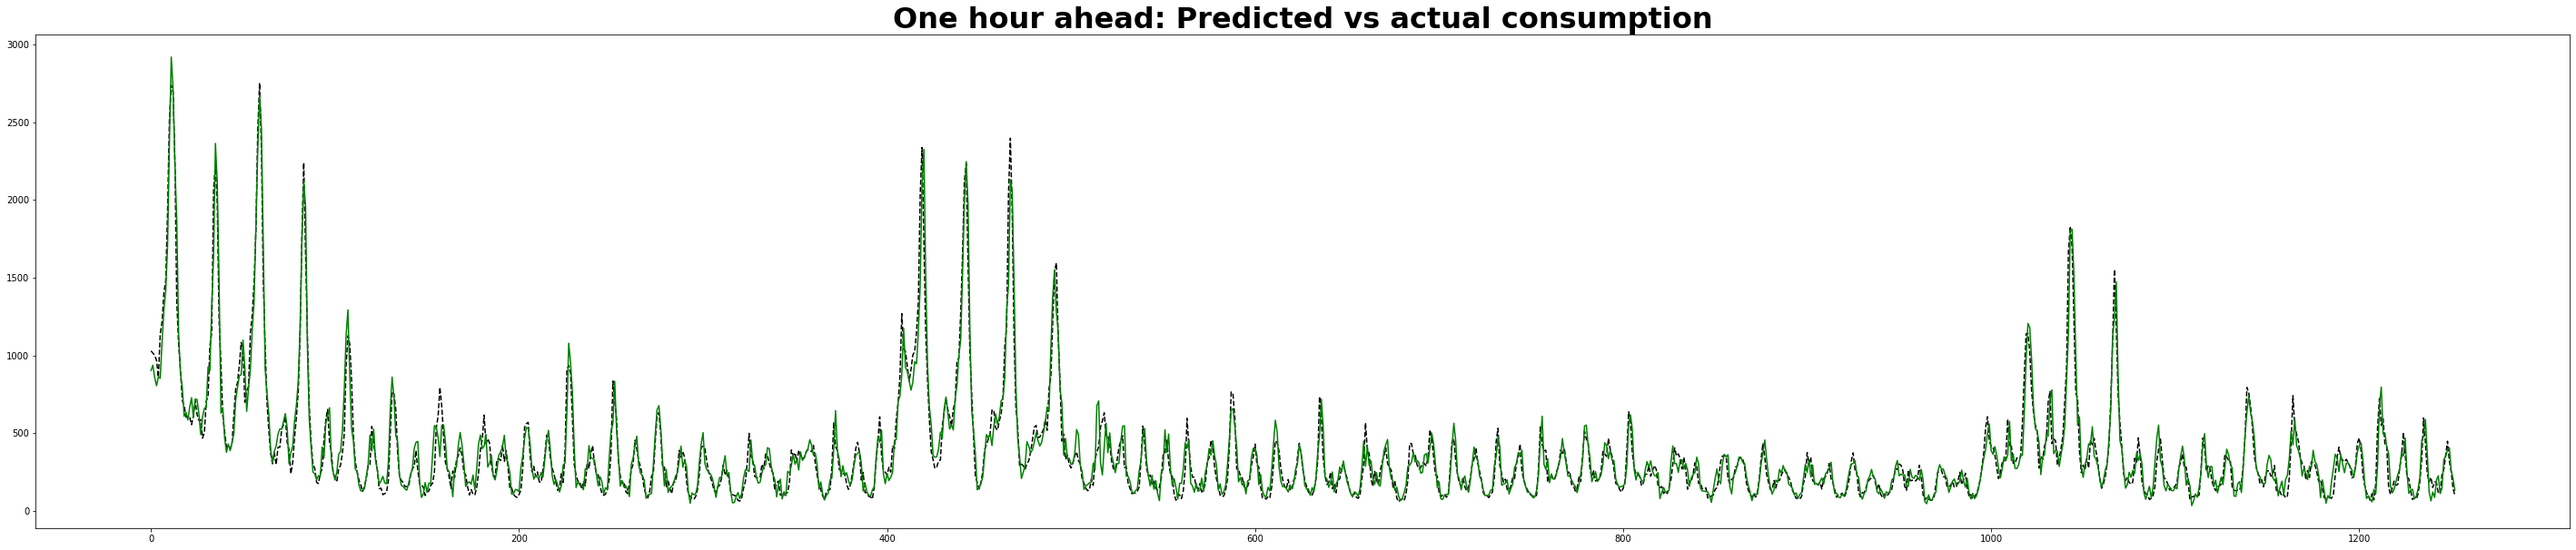

In [45]:
test_Y_pred = lr.predict(test_X)
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y[:,0], '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred[:,0], 'g')
plt.title('One hour ahead: Predicted vs actual consumption', fontsize = 32, fontweight= 'bold')

In [46]:
mae_lm_test = calc_mae(y=test_Y[:,0], y_pred=test_Y_pred[:,0])
mse_lm_test = calc_mse(y=test_Y[:,0], y_pred=test_Y_pred[:,0])

The Mean Absolute Error is:  66
The Mean Square Error is:  9488


In [48]:
mae_lm_test = calc_mae(y=test_Y, y_pred=test_Y_pred)
print('\n')
mse_lm_test = calc_mse(y=test_Y, y_pred=test_Y_pred)


The Mean Absolute Error is:  [ 66  93 113 128 137 144 148 151 153 154 154 154 154 154 153 153 152 152
 152 152 152 152 152 155]


The Mean Square Error is:  [ 9488 19774 29310 36670 42156 46419 48930 50582 52215 53401 54508 55670
 56386 56361 56061 56199 56049 55838 55557 55129 54855 54482 54209 54470]


In [49]:
print("MAE (overall)", int(np.sum(mae_lm_test)/len(mae_lm_test)) )
print("MSE (overall)", int(np.sum(mse_lm_test)/len(mse_lm_test)) )
      

MAE (overall) 143
MSE (overall) 48530


### Train NN (without weather data)

In [50]:
# Instanstiating model

model = Sequential()
model.add(Dense(50, input_dim=24*6, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(24, activation='linear'))

# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [51]:
# fit the keras model on the dataset
model.fit(train_X, train_Y, epochs=150, batch_size=10)


Epoch 1/150
2924/2924 [==============================] - 2s 695us/step - loss: 257083.5839 - mean_absolute_error: 323.5787
Epoch 2/150
2924/2924 [==============================] - 0s 155us/step - loss: 168311.3783 - mean_absolute_error: 266.1493
Epoch 3/150
2924/2924 [==============================] - 0s 166us/step - loss: 147177.8778 - mean_absolute_error: 247.0094
Epoch 4/150
2924/2924 [==============================] - 1s 203us/step - loss: 133492.5559 - mean_absolute_error: 236.0776
Epoch 5/150
2924/2924 [==============================] - 0s 166us/step - loss: 127451.9564 - mean_absolute_error: 230.3733
Epoch 6/150
2924/2924 [==============================] - 0s 144us/step - loss: 124809.4199 - mean_absolute_error: 226.8075
Epoch 7/150
2924/2924 [==============================] - 0s 150us/step - loss: 117611.0283 - mean_absolute_error: 221.2056
Epoch 8/150
2924/2924 [==============================] - 0s 144us/step - loss: 117010.0516 - mean_absolute_error: 220.6752
Epoch 9/150
292

Epoch 131/150
2924/2924 [==============================] - 0s 144us/step - loss: 63360.2733 - mean_absolute_error: 162.6949
Epoch 132/150
2924/2924 [==============================] - 0s 144us/step - loss: 63512.7657 - mean_absolute_error: 164.1860
Epoch 133/150
2924/2924 [==============================] - 0s 150us/step - loss: 59261.8666 - mean_absolute_error: 157.9887
Epoch 134/150
2924/2924 [==============================] - 0s 155us/step - loss: 62486.7653 - mean_absolute_error: 162.3843
Epoch 135/150
2924/2924 [==============================] - 0s 144us/step - loss: 61375.2525 - mean_absolute_error: 160.8416 0s - loss: 57942.8845 - mean_absolute_error: 157.
Epoch 136/150
2924/2924 [==============================] - 0s 150us/step - loss: 59544.8843 - mean_absolute_error: 159.3508
Epoch 137/150
2924/2924 [==============================] - 0s 144us/step - loss: 60456.7507 - mean_absolute_error: 159.7156
Epoch 138/150
2924/2924 [==============================] - 0s 144us/step - loss: 6

In [52]:
test_Y_pred = model.predict(test_X)
MAE = metrics.mean_absolute_error(test_Y , test_Y_pred)
MSE = metrics.mean_squared_error(test_Y, test_Y_pred)

print('MAE = ', int(MAE))
print('MSE = ', int(MSE))


MAE =  136
MSE =  46040


In [53]:
# Evaluating the MSE for each time shifted output separately
MAE_sep = [0] * test_Y.shape[1]
MSE_sep = [0] * test_Y.shape[1]

for k in range(test_Y.shape[1]):
    MAE_sep[k] = int(metrics.mean_absolute_error(test_Y[:,k] , test_Y_pred[:,k]))
    MSE_sep[k] = int(metrics.mean_squared_error(test_Y[:,k], test_Y_pred[:,k]))

print('The mean absolute error of each hour ahead forecast is:', MAE_sep)
print('\n')
print('The mean squared error of each hour ahead forecast is:', MSE_sep)

The mean absolute error of each hour ahead forecast is: [94, 109, 115, 123, 128, 129, 132, 134, 138, 138, 139, 139, 144, 149, 150, 147, 146, 146, 148, 147, 144, 143, 140, 137]


The mean squared error of each hour ahead forecast is: [18413, 26820, 30919, 35041, 36683, 37928, 40334, 41101, 43690, 46595, 48621, 50693, 53113, 55747, 56679, 55405, 54911, 53271, 54248, 54240, 54290, 53784, 51869, 50566]


Text(0.5, 1.0, 'Predicted vs Actual all hours')

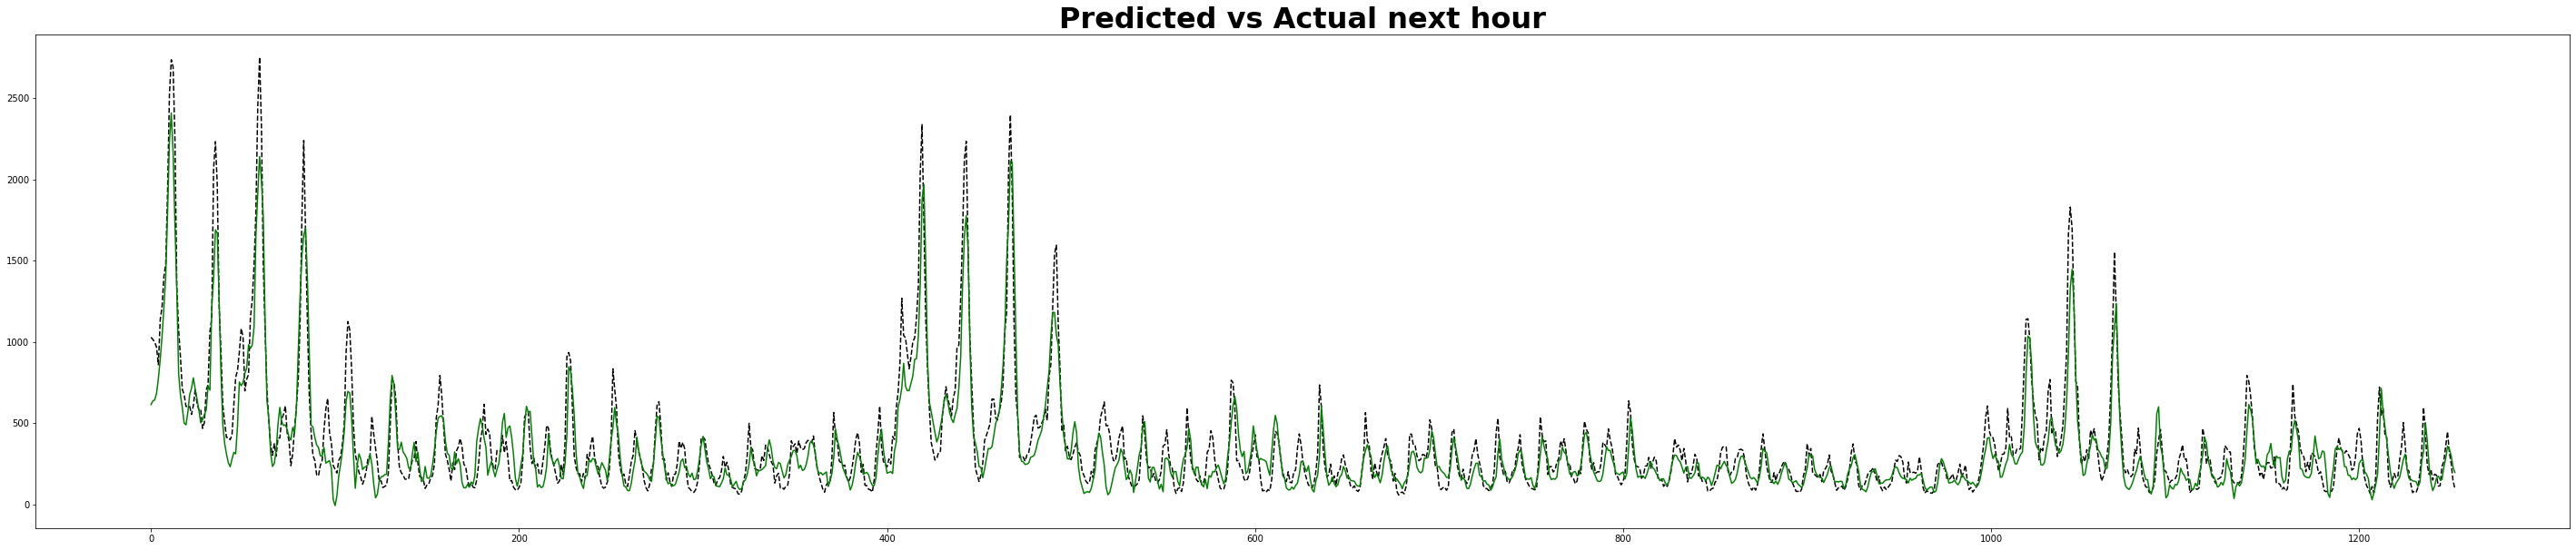

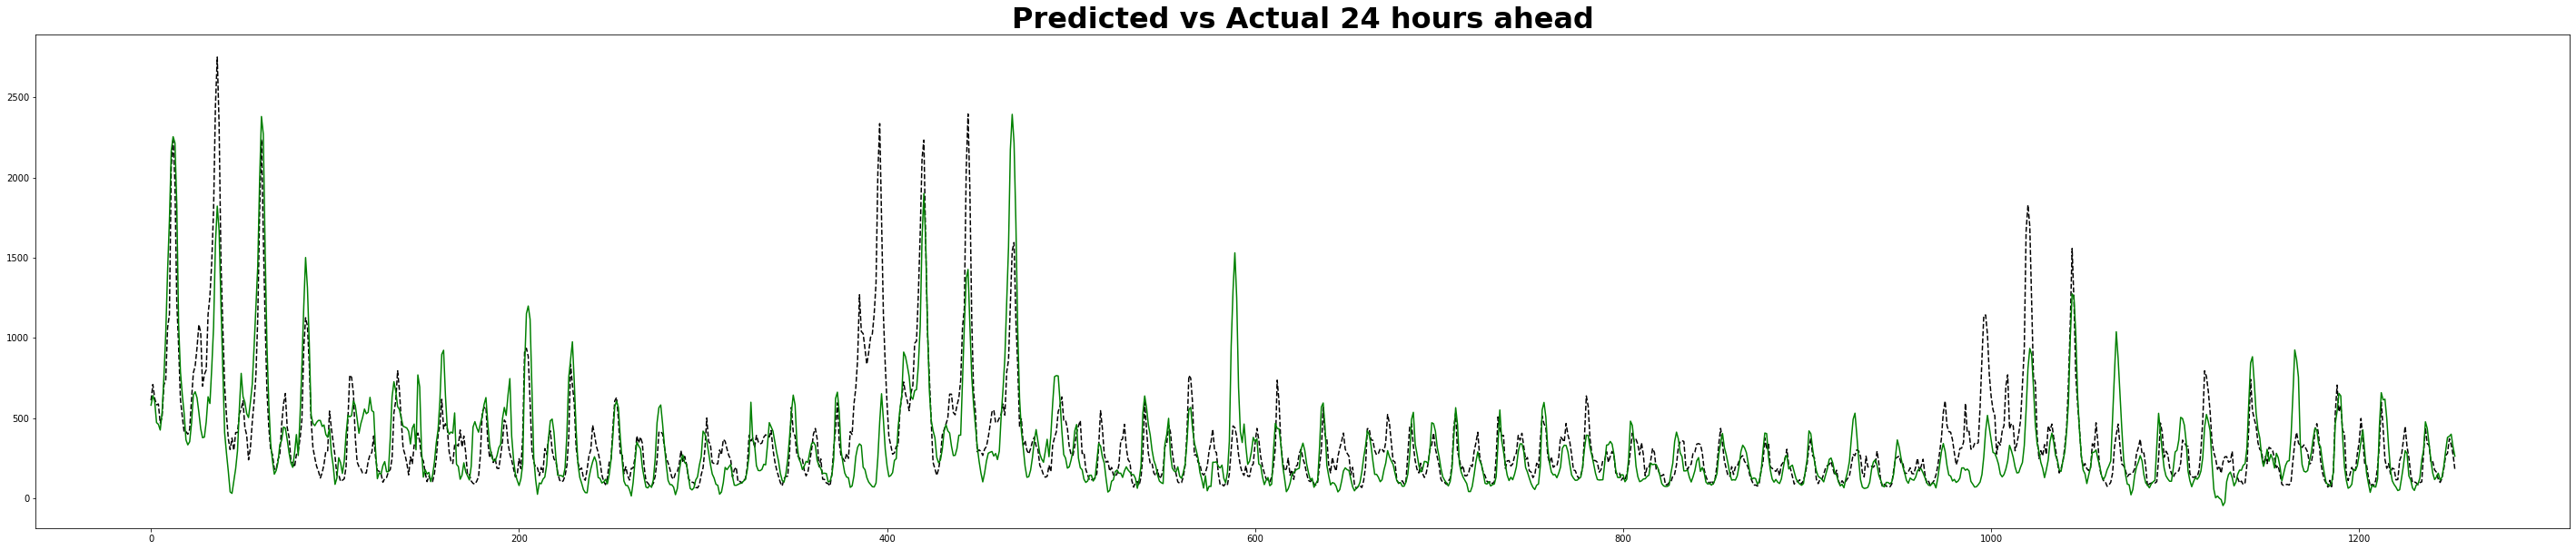

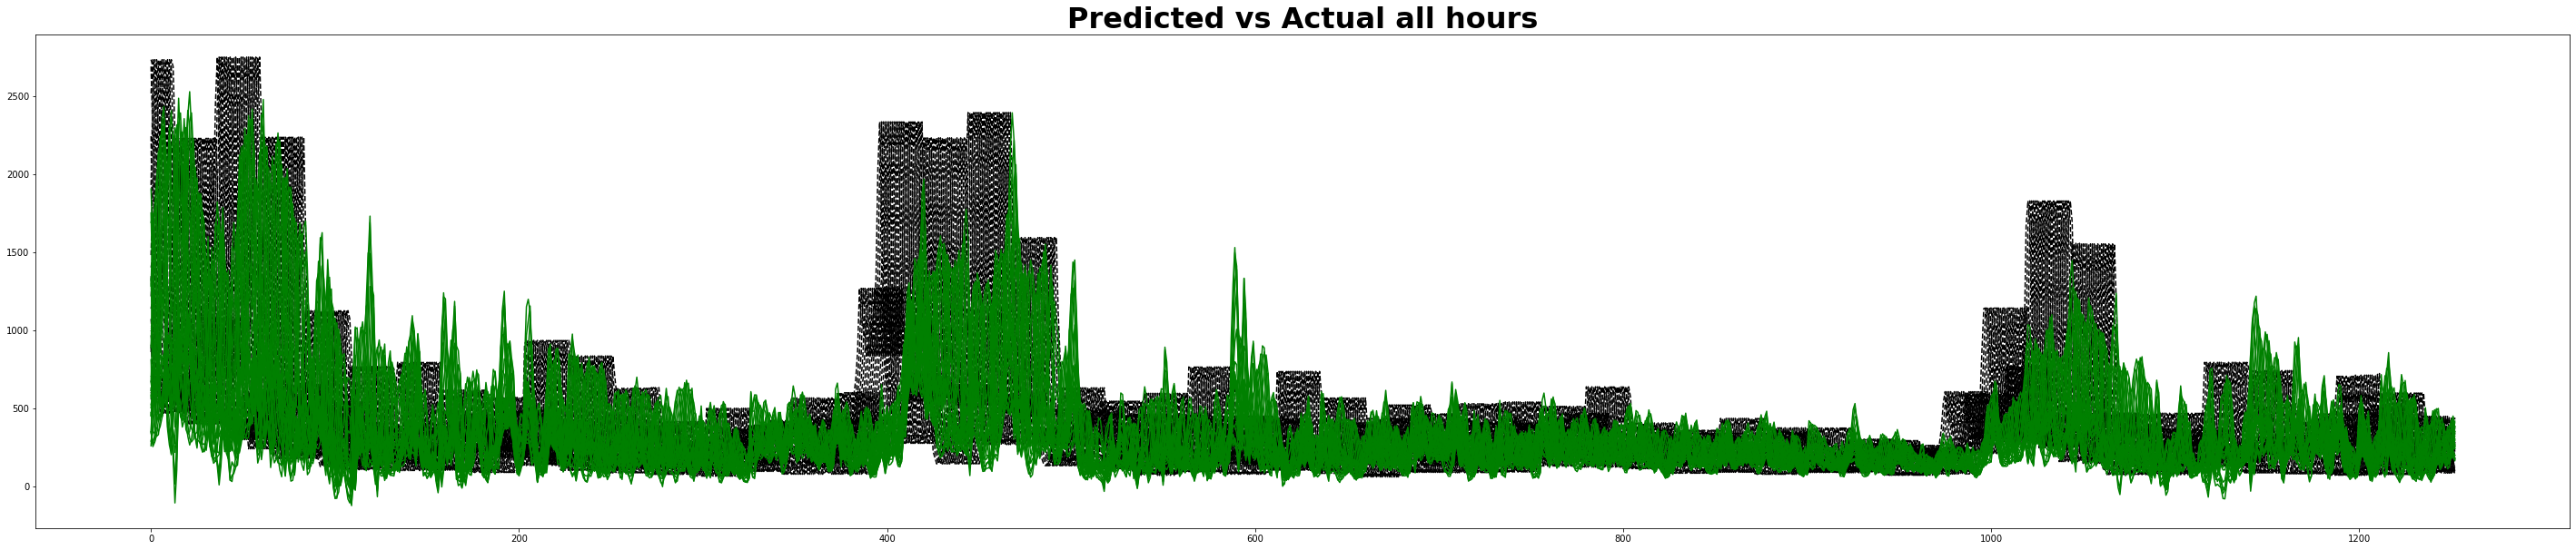

In [54]:
# Plotting several time series outputs

# Predicted vs Actual next hour
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y[:, 0], '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred[:, 0], 'g')
plt.title('Predicted vs Actual next hour', fontsize = 32, fontweight= 'bold')

# Predicted vs Actual final hour
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y[:, 23], '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred[:, 23], 'g')
plt.title('Predicted vs Actual 24 hours ahead', fontsize = 32, fontweight= 'bold')

#Predicted vs Actual total
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y, '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred, 'g')
plt.title('Predicted vs Actual all hours' , fontsize = 32, fontweight= 'bold')

### Incorporating weather data

This section explores whether or not including weather data (namely, temeprature and precipitation) improves the generated model. The weather data used is in fact the actual recorded temeprature and rainfall for the day; in real life this data will of course not be available for prediction, and so the subsequent analysis and conclusions assume that the forecasted weather data available to the system operators is very accurate. 

The weather data was obtained from the following source: https://www.ncdc.noaa.gov/cdo-web/search. 

In [55]:
#Code to generate daily temperature data

In [56]:
rawData = pd.read_csv('ClimateData_Mueller.csv')
rawData.head()

STATION                             NAME  LATITUDE  LONGITUDE  \
0  US1TXTV0059  TANGLEWOOD FOREST 0.6 NE, TX US   30.1807   -97.8315   
1  US1TXTV0059  TANGLEWOOD FOREST 0.6 NE, TX US   30.1807   -97.8315   
2  US1TXTV0059  TANGLEWOOD FOREST 0.6 NE, TX US   30.1807   -97.8315   
3  US1TXTV0059  TANGLEWOOD FOREST 0.6 NE, TX US   30.1807   -97.8315   
4  US1TXTV0059  TANGLEWOOD FOREST 0.6 NE, TX US   30.1807   -97.8315   

   ELEVATION        DATE  DAPR  MDPR  PRCP  SNOW  SNWD  TAVG  TMAX  TMIN  TOBS  
0      241.1  2015-10-01   NaN   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN  
1      241.1  2015-10-02   NaN   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN  
2      241.1  2015-10-03   NaN   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN  
3      241.1  2015-10-04   NaN   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN  
4      241.1  2015-10-05   NaN   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN

In [57]:
rawData = rawData[rawData.NAME=='AUSTIN CAMP MABRY, TX US']
rawData = rawData.drop(["STATION","NAME","LATITUDE","LONGITUDE","ELEVATION","DAPR","MDPR","SNWD","TOBS"], axis=1)
rawData['TAVG']=(rawData['TMAX']+rawData['TMIN'])/2

In [58]:
tempData = pd.DataFrame(np.repeat(rawData.values,24,axis=0))
tempData.columns = ["DateTime","Precipitation","Snowfall","Daily average temperature","Max temperature","Min temperature"]
tempData.head()

DateTime Precipitation Snowfall Daily average temperature  \
0  2015-10-01             0        0                      27.5   
1  2015-10-01             0        0                      27.5   
2  2015-10-01             0        0                      27.5   
3  2015-10-01             0        0                      27.5   
4  2015-10-01             0        0                      27.5   

  Max temperature Min temperature  
0            34.4            20.6  
1            34.4            20.6  
2            34.4            20.6  
3            34.4            20.6  
4            34.4            20.6

In [59]:
dateTime = pd.read_csv('hourly_reading_dataset.csv')
dateTime.head()
len(dateTime)

436538

In [60]:
x=dateTime[dateTime.dataid==35]
xdtime=x['datetime']
xdtime.head()

0    2015-10-01 00:00:00
1    2015-10-01 01:00:00
2    2015-10-01 02:00:00
3    2015-10-01 03:00:00
4    2015-10-01 04:00:00
Name: datetime, dtype: object

In [61]:
tempData['DateTime']=xdtime
tempData.tail()

DateTime Precipitation Snowfall Daily average temperature  \
4387  2016-03-31 19:00:00             0        0                     24.45   
4388  2016-03-31 20:00:00             0        0                     24.45   
4389  2016-03-31 21:00:00             0        0                     24.45   
4390  2016-03-31 22:00:00             0        0                     24.45   
4391  2016-03-31 23:00:00             0        0                     24.45   

     Max temperature Min temperature  
4387              30            18.9  
4388              30            18.9  
4389              30            18.9  
4390              30            18.9  
4391              30            18.9

In [62]:
# Load in weather data

weather_df = tempData
weather_df['DateTime'] = pd.to_datetime(weather_df.DateTime, format = '%Y-%m-%d %H:%M:%S') # format as time
weather_df.head()


DateTime Precipitation Snowfall Daily average temperature  \
0 2015-10-01 00:00:00             0        0                      27.5   
1 2015-10-01 01:00:00             0        0                      27.5   
2 2015-10-01 02:00:00             0        0                      27.5   
3 2015-10-01 03:00:00             0        0                      27.5   
4 2015-10-01 04:00:00             0        0                      27.5   

  Max temperature Min temperature  
0            34.4            20.6  
1            34.4            20.6  
2            34.4            20.6  
3            34.4            20.6  
4            34.4            20.6

In [63]:
# Merge weather data into aggregated demand dataframe

df_mean_with_weather = pd.merge(df_mean, 
                                weather_df[['DateTime', 'Precipitation', 'Daily average temperature']],
                                on='DateTime')

df_mean_with_weather.head()

DateTime          y        y+1         y+2         y+3  \
0 2015-10-08 00:00:00  69.771222  74.617667   62.928444   59.626333   
1 2015-10-08 01:00:00  74.617667  62.928444   59.626333   55.884778   
2 2015-10-08 02:00:00  62.928444  59.626333   55.884778   86.193889   
3 2015-10-08 03:00:00  59.626333  55.884778   86.193889  190.241778   
4 2015-10-08 04:00:00  55.884778  86.193889  190.241778  307.899889   

          y+4         y+5         y+6         y+7         y+8  ...  \
0   55.884778   86.193889  190.241778  307.899889  253.019556  ...   
1   86.193889  190.241778  307.899889  253.019556  235.755667  ...   
2  190.241778  307.899889  253.019556  235.755667  186.023111  ...   
3  307.899889  253.019556  235.755667  186.023111  143.623000  ...   
4  253.019556  235.755667  186.023111  143.623000   85.013667  ...   

        y-137       y-138       y-139       y-140       y-141       y-142  \
0  252.253667  183.574778   53.662444   50.912778   70.273444   52.758444   
1  291.389333  252.253667  183.574778   53.662444   50.912778   70.273444   
2  162.029444  291.389333  252.253667  183.574778   53.662444   50.912778   
3  133.942667  162.029444  291.389333  252.253667  183.574778   53.662444   
4   99.025667  133.942667  162.029444  291.389333  252.253667  183.574778   

       y-143      y-144  Precipitation  Daily average temperature  
0  71.190000  81.460444              0                       26.4  
1  52.758444  71.190000              0                       26.4  
2  70.273444  52.758444              0                       26.4  
3  50.912778  70.273444              0                       26.4  
4  53.662444  50.912778              0                       26.4  

[5 rows x 171 columns]

In [64]:
# Separating input and output variables 
dataset = df_mean_with_weather.values
X = dataset[:,25::] # prior consumption + daily avg temp and precipitation
Y = dataset[:,1:25]

#Separating train and test data
split_1 = round(len(X)*0.7)
train_X = X[0:split_1, :]
test_X = X[split_1::,:]
assert len(X) == len(train_X)+len(test_X)
train_Y = Y[0:split_1]
test_Y = Y[split_1::]


In [65]:
# Instanstiating model

model = Sequential()
model.add(Dense(50, input_dim=24*6+2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(24, activation='linear'))

# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [66]:
# Fit the keras model on the dataset
model.fit(train_X, train_Y, epochs=150, batch_size=10)

Epoch 1/150
2924/2924 [==============================] - 1s 294us/step - loss: 271865.0173 - mean_absolute_error: 332.4922
Epoch 2/150
2924/2924 [==============================] - 0s 144us/step - loss: 172730.3906 - mean_absolute_error: 268.8367
Epoch 3/150
2924/2924 [==============================] - 0s 150us/step - loss: 149677.5322 - mean_absolute_error: 250.9173
Epoch 4/150
2924/2924 [==============================] - 0s 139us/step - loss: 139982.0634 - mean_absolute_error: 241.0613
Epoch 5/150
2924/2924 [==============================] - 0s 144us/step - loss: 130146.9035 - mean_absolute_error: 233.8759
Epoch 6/150
2924/2924 [==============================] - 0s 144us/step - loss: 125123.3082 - mean_absolute_error: 228.8867
Epoch 7/150
2924/2924 [==============================] - 0s 144us/step - loss: 120115.3069 - mean_absolute_error: 223.4634
Epoch 8/150
2924/2924 [==============================] - 0s 150us/step - loss: 117245.4332 - mean_absolute_error: 219.8213
Epoch 9/150
2924

2924/2924 [==============================] - 0s 150us/step - loss: 60761.2246 - mean_absolute_error: 161.0821
Epoch 134/150
2924/2924 [==============================] - 0s 150us/step - loss: 59503.5284 - mean_absolute_error: 159.1437
Epoch 135/150
2924/2924 [==============================] - 0s 144us/step - loss: 60941.5155 - mean_absolute_error: 160.4258
Epoch 136/150
2924/2924 [==============================] - 0s 144us/step - loss: 59427.7199 - mean_absolute_error: 159.3684
Epoch 137/150
2924/2924 [==============================] - 0s 150us/step - loss: 60362.1587 - mean_absolute_error: 161.1285
Epoch 138/150
2924/2924 [==============================] - 0s 150us/step - loss: 59598.8503 - mean_absolute_error: 159.1708
Epoch 139/150
2924/2924 [==============================] - 0s 155us/step - loss: 62703.7367 - mean_absolute_error: 162.7883
Epoch 140/150
2924/2924 [==============================] - 0s 150us/step - loss: 59409.5587 - mean_absolute_error: 159.6882
Epoch 141/150
2924/292

In [67]:
test_Y_pred = model.predict(test_X)
MAE = metrics.mean_absolute_error(test_Y , test_Y_pred)
MSE = metrics.mean_squared_error(test_Y, test_Y_pred)

print('MAE = ', int(MAE))
print('MSE = ', int(MSE))


MAE =  131
MSE =  47855


In [68]:
# Evaluating the MSE for each time shifted output separately
MAE_sep = [0] * test_Y.shape[1]
MSE_sep = [0] * test_Y.shape[1]

for k in range(test_Y.shape[1]):
    MAE_sep[k] = int(metrics.mean_absolute_error(test_Y[:,k] , test_Y_pred[:,k]))
    MSE_sep[k] = int(metrics.mean_squared_error(test_Y[:,k], test_Y_pred[:,k]))

print('The mean absolute error of each hour ahead forecast is:', MAE_sep)
print('\n')
print('The mean squared error of each hour ahead forecast is:', MSE_sep)

The mean absolute error of each hour ahead forecast is: [88, 102, 110, 109, 116, 124, 127, 129, 128, 132, 135, 137, 142, 147, 148, 150, 146, 145, 144, 141, 141, 139, 137, 136]


The mean squared error of each hour ahead forecast is: [16555, 24316, 30164, 30187, 35150, 39620, 40250, 41823, 43057, 47031, 48545, 50482, 54157, 58192, 59213, 60420, 58789, 58969, 60480, 61016, 60498, 58240, 55794, 55566]


Text(0.5, 1.0, 'Predicted vs Actual all hours')

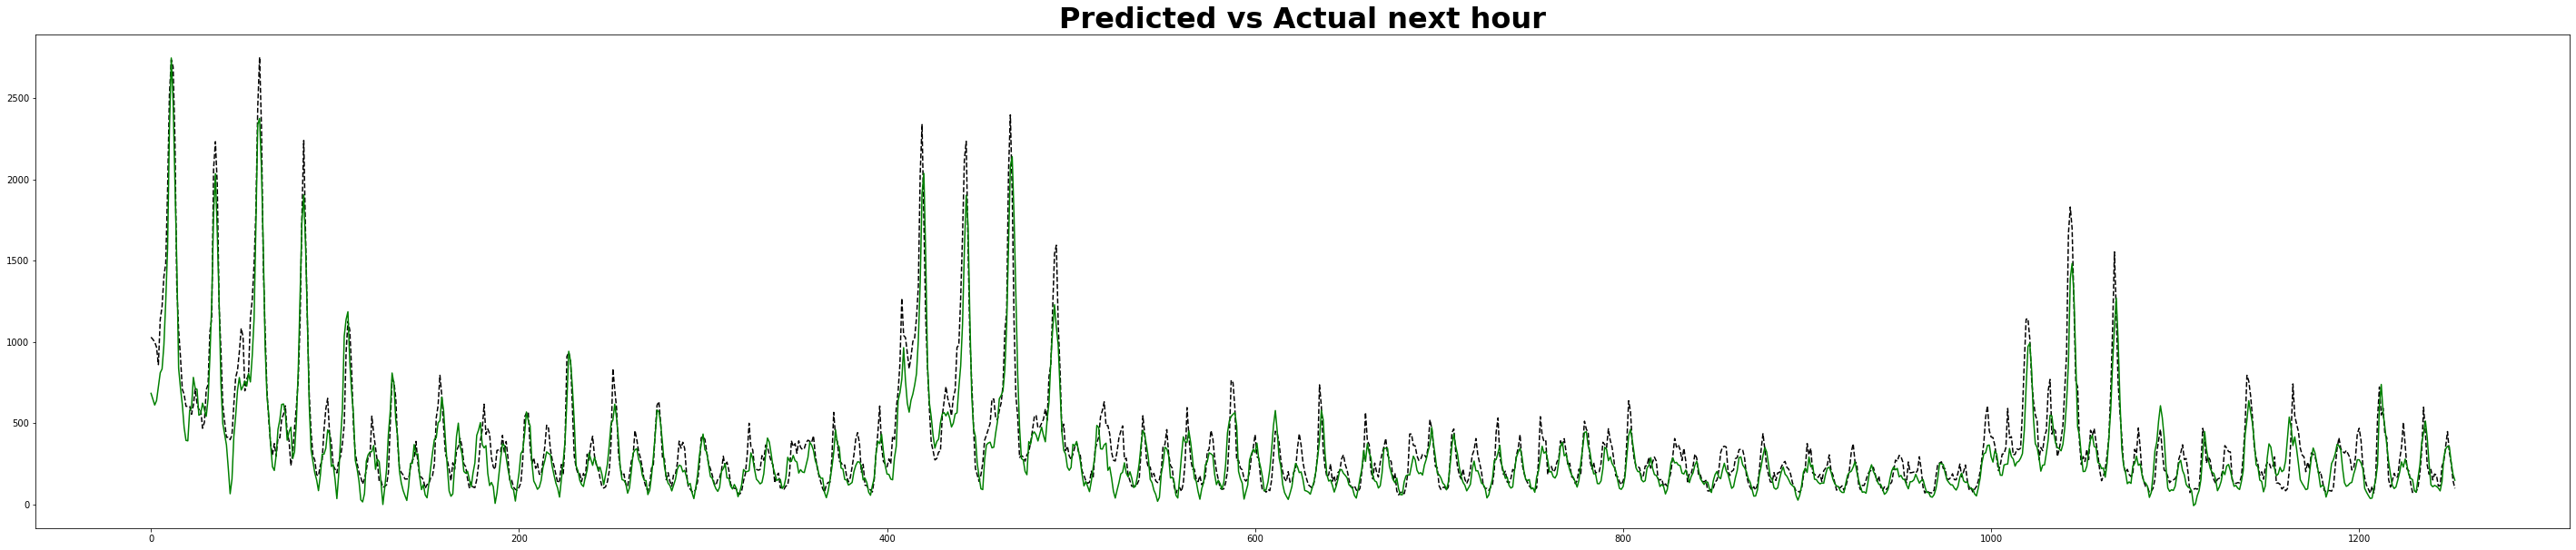

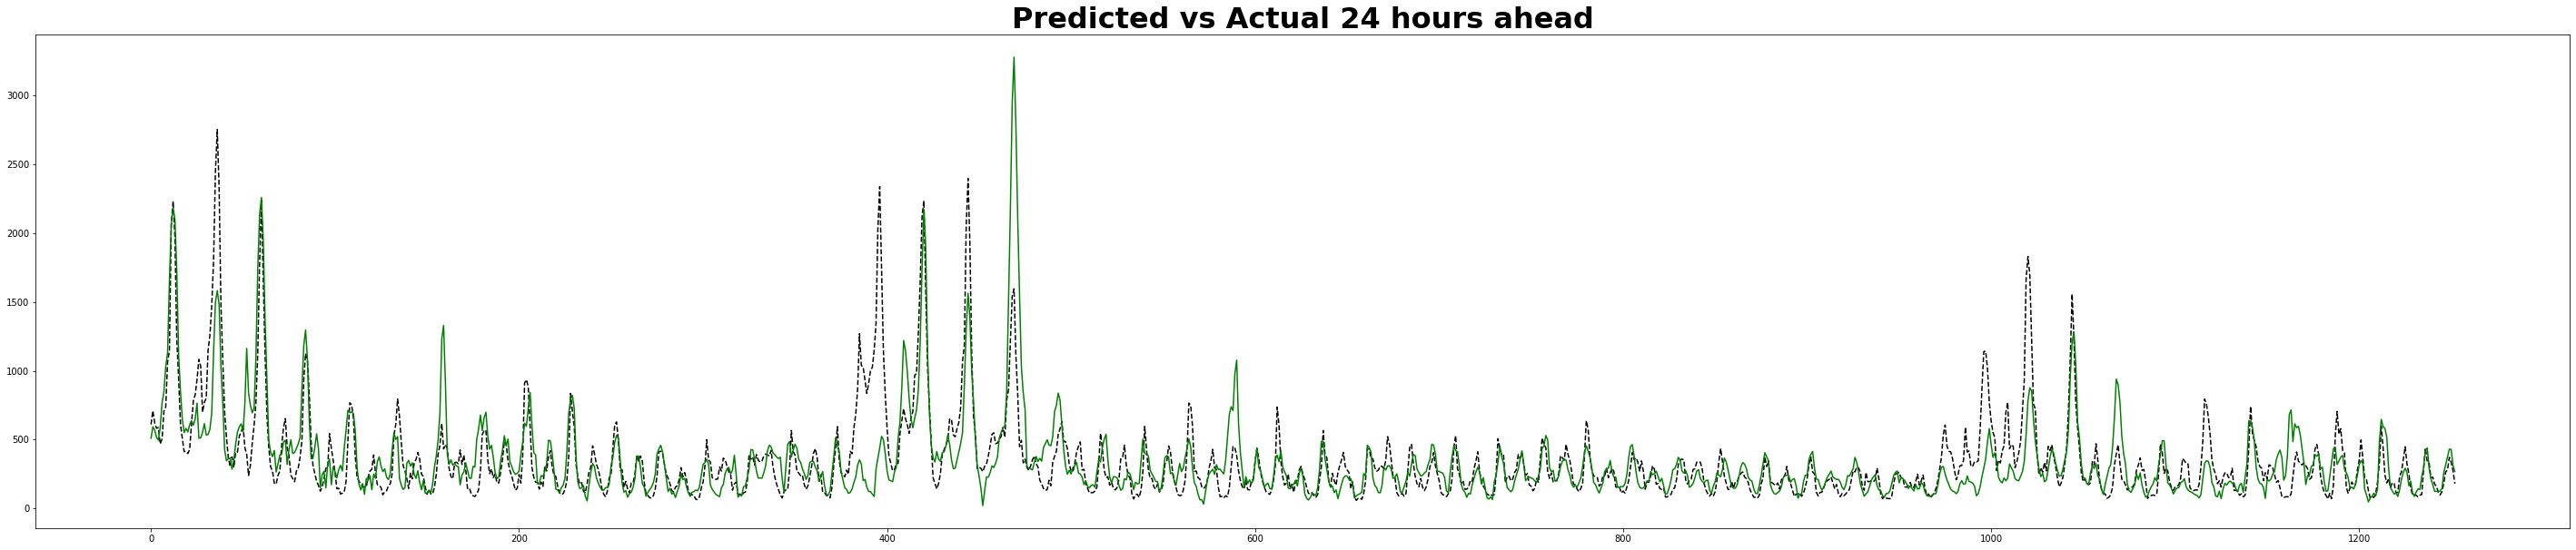

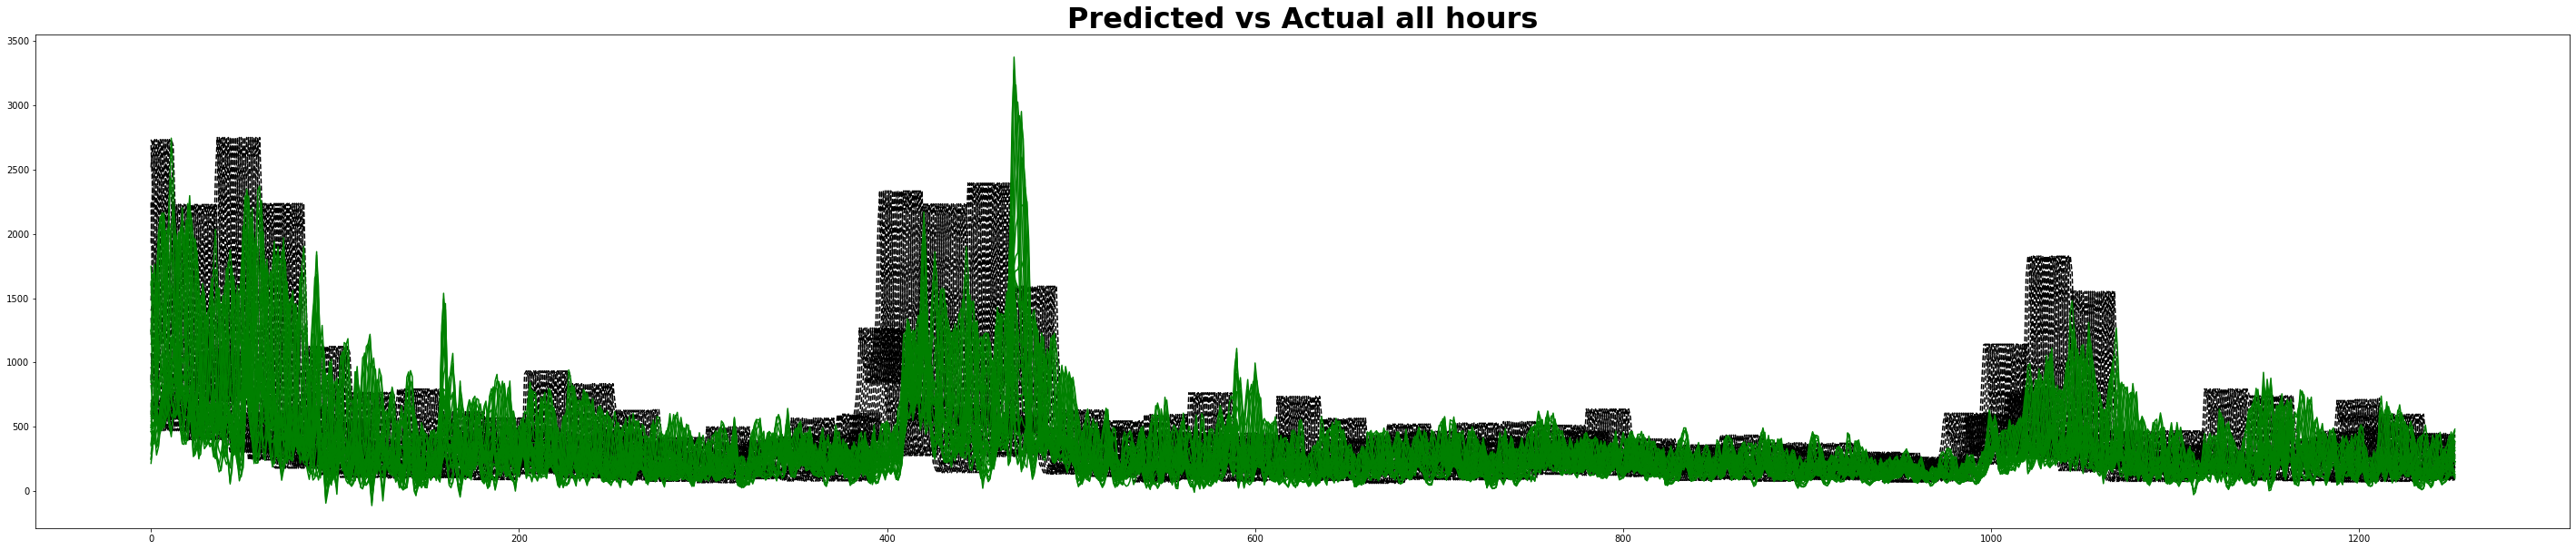

In [69]:
# Plotting several time series outputs

# Predicted vs Actual next hour
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y[:, 0], '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred[:, 0], 'g')
plt.title('Predicted vs Actual next hour', fontsize = 32, fontweight= 'bold')

# Predicted vs Actual final hour
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y[:, 23], '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred[:, 23], 'g')
plt.title('Predicted vs Actual 24 hours ahead', fontsize = 32, fontweight= 'bold')

#Predicted vs Actual total
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
ax.plot(range(0,len(test_Y)), test_Y, '--k')
ax.plot(range(0,len(test_Y)), test_Y_pred, 'g')
plt.title('Predicted vs Actual all hours' , fontsize = 32, fontweight= 'bold')